# Waterpoint Dataset
### To predict operating condition of the Waterpoint

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz

In [3]:
!tar xf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark

In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content//spark-3.0.1-bin-hadoop2.7"

In [5]:
import findspark
findspark.init()

In [6]:
!pip install pyspark==3.0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 MB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 9.8 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612229 sha256=256e1e0bd123ca55dd59861188d43a5f146d08b7f525f748a61ba246ba992a9d
  Stored in directory: /root/.cache/pip/wheels/19/b0/c8/6cb894117070e130fc44352c2a13f15b6c27e440d04a84fb48
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
import pyspark.sql.functions as sqlF

# Pyspark ml libraries
from pyspark.ml.feature import Imputer, VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression

#Visualisation libraries
import plotly.graph_objects as go
import plotly.express as px

import seaborn as sns
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
# To specify the master node run this line
# spark = SparkSession.builder.appName('Big Data Project').master("local[*]").getOrCreate()

#If we dont specify the master, the default is local[*]
# spark = SparkSession.builder.appName('Big Data Project').config("spark.driver.maxResultSize", "11g").config("spark.driver.memory", "11g").getOrCreate()
spark = SparkSession.builder.appName('Big Data Project').getOrCreate()

In [10]:
spark

In [11]:
sc = spark.sparkContext

## Task1: Create RDD, Dataframe and schema for the two files. (10 marks)

In [12]:
#Creating Waterpoint data values RDD
dataRDD = sc.textFile('/content/drive/MyDrive/BigData_Project/waterpoint_data_values.csv')

#Creating Waterpoint data labels RDD
labelsRDD = sc.textFile('/content/drive/MyDrive/BigData_Project/waterpoint_data_labels.csv')

In [13]:
#Excluding the header for both the rdds
dataRDD_header = dataRDD.first()
dataRDD = dataRDD.filter(lambda line: line != dataRDD_header)

labelRDD_header = labelsRDD.first()
labelsRDD = labelsRDD.filter(lambda line: line != labelRDD_header)

In [14]:
# Splitting the rows by ','

dataRDD = dataRDD.map(lambda x: x.split(","))
labelsRDD = labelsRDD.map(lambda x: x.split(","))

In [15]:
dataRDD.take(1)

[['69572',
  '6000',
  '2011-03-14',
  'Roman',
  '1390',
  'Roman',
  '34.93809275',
  '-9.85632177',
  'none',
  '0',
  'Lake Nyasa',
  'Mnyusi B',
  'Iringa',
  '11',
  '5',
  'Ludewa',
  'Mundindi',
  '109',
  'True',
  'GeoData Consultants Ltd',
  'VWC',
  'Roman',
  'False',
  '1999',
  'gravity',
  'gravity',
  'gravity',
  'vwc',
  'user-group',
  'pay annually',
  'annually',
  'soft',
  'good',
  'enough',
  'enough',
  'spring',
  'spring',
  'groundwater',
  'communal standpipe',
  'communal standpipe']]

In [16]:
#Creating data values data frame
data_values_df = spark.read.format("csv")\
.option("inferSchema", "true")\
.option("header", "true")\
.load("/content/drive/MyDrive/BigData_Project/waterpoint_data_values.csv")

#Creating data labels dataframe
data_labels_df = spark.read.format("csv")\
.option("inferSchema", "true")\
.option("header", "true")\
.load("/content/drive/MyDrive/BigData_Project/waterpoint_data_labels.csv")

In [17]:
data_values_df.show(5)

+-----+----------+-------------+------------+----------+------------+-----------+------------+--------------------+-----------+--------------------+----------+-------+-----------+-------------+---------+----------+----------+--------------+--------------------+-----------------+--------------------+------+-----------------+---------------+---------------------+---------------------+----------+----------------+--------------+------------+-------------+-------------+------------+--------------+--------------------+--------------------+------------+--------------------+---------------------+
|   id|amount_tsh|date_recorded|      funder|gps_height|   installer|  longitude|    latitude|            wpt_name|num_private|               basin|subvillage| region|region_code|district_code|      lga|      ward|population|public_meeting|         recorded_by|scheme_management|         scheme_name|permit|construction_year|extraction_type|extraction_type_group|extraction_type_class|management|manageme

In [18]:
data_labels_df.show(5)

+-----+--------------+
|   id|  status_group|
+-----+--------------+
|69572|    functional|
| 8776|    functional|
|34310|    functional|
|67743|non functional|
|19728|    functional|
+-----+--------------+
only showing top 5 rows



## Task2: Verify the row counts of the two dataFrames and check whether the counts are matching or not. (5 marks)

In [19]:
#Number of records in values
print("Number of records in values ",data_values_df.count())
#Number of records in labels
print("Number of records in labels ",data_labels_df.count())

Number of records in values  59400
Number of records in labels  59400


## Task3: Verify first few rows of both the dataFrames and identify the common column name (key). (2 marks)

In [20]:
# First four rows of values dataframe
data_values_df.show(4)

+-----+----------+-------------+------------+----------+------------+-----------+------------+--------------------+-----------+--------------------+----------+-------+-----------+-------------+---------+--------+----------+--------------+--------------------+-----------------+--------------------+------+-----------------+---------------+---------------------+---------------------+----------+----------------+--------------+------------+-------------+-------------+------------+--------------+--------------------+--------------------+------------+--------------------+---------------------+
|   id|amount_tsh|date_recorded|      funder|gps_height|   installer|  longitude|    latitude|            wpt_name|num_private|               basin|subvillage| region|region_code|district_code|      lga|    ward|population|public_meeting|         recorded_by|scheme_management|         scheme_name|permit|construction_year|extraction_type|extraction_type_group|extraction_type_class|management|management_g

In [21]:
#First 4 rows of labels dataframe
data_labels_df.show(4)

+-----+--------------+
|   id|  status_group|
+-----+--------------+
|69572|    functional|
| 8776|    functional|
|34310|    functional|
|67743|non functional|
+-----+--------------+
only showing top 4 rows



#### We can see that ID is the common column name (Key)

In [22]:
'''Performing intersection between the id columns of both dataframes if all the ids are present
   in both the data frames'''
idsIntersection = data_values_df.select('id').intersect(data_labels_df.select('id'))
idsIntersection.count()

59400

## Task4: Create a DataFrame in cache . (2 marks)

In [23]:
#Joining the values and labels dataframes and storing it in cache. Any further operations on joined_data_df will be
#performed on the cached dataframe.

joined_data_df = data_values_df.join(data_labels_df, ['id']).cache()


## Task5: Verify the row counts after the combined Data Frame. (3 marks)

In [24]:
joined_data_df.count()

59400

In [25]:
joined_data_df.show(5)

+-----+----------+-------------+------------+----------+------------+-----------+------------+--------------------+-----------+--------------------+----------+-------+-----------+-------------+---------+----------+----------+--------------+--------------------+-----------------+--------------------+------+-----------------+---------------+---------------------+---------------------+----------+----------------+--------------+------------+-------------+-------------+------------+--------------+--------------------+--------------------+------------+--------------------+---------------------+--------------+
|   id|amount_tsh|date_recorded|      funder|gps_height|   installer|  longitude|    latitude|            wpt_name|num_private|               basin|subvillage| region|region_code|district_code|      lga|      ward|population|public_meeting|         recorded_by|scheme_management|         scheme_name|permit|construction_year|extraction_type|extraction_type_group|extraction_type_class|mana

## Task6: Verify the distribution for the target variable using Spark SQL and visualize the distribution using plots. (5 Marks)

In [26]:
joined_data_df.createOrReplaceTempView("waterpointData")

In [27]:
# Calculate the frequency of each category in the target variable
freq = spark.sql("SELECT status_group, COUNT(*) AS frequency FROM waterpointData GROUP BY status_group")

# Show the frequency table
freq.show(truncate=False)

+-----------------------+---------+
|status_group           |frequency|
+-----------------------+---------+
|functional needs repair|4317     |
|functional             |32259    |
|non functional         |22824    |
+-----------------------+---------+



In [28]:
status_group_list = freq.select(sqlF.collect_list("status_group")).first()[0]
frequency_list = freq.select(sqlF.collect_list("frequency")).first()[0]

colors = ['gold', 'mediumturquoise', 'darkorange']

fig = go.Figure(data=[go.Pie(labels=status_group_list,
                             values=frequency_list)])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))

fig.show()

## Task7: For the categorical variables ‘construction_year’,’water_quality’, find the distribution of these variables with the target variable ‘status_group’. Visualize the data for these data frames. (5 Marks)

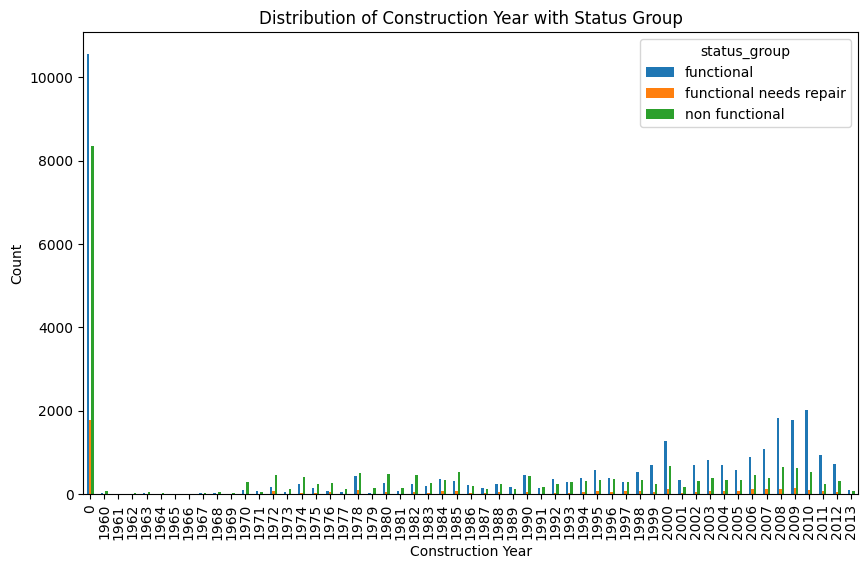

In [29]:
# Group the data by construction_year and status_group and count the occurrences
grouped = joined_data_df.groupby(["construction_year", "status_group"]).count()

# Convert the result to a Pandas DataFrame
result = grouped.toPandas()

# Pivot the data to create a matrix with construction_year as rows, status_group as columns, and count as values
result_pivot = result.pivot(index="construction_year", columns="status_group", values="count")

# Create a stacked bar plot of the result using Matplotlib
result_pivot.plot(kind="bar", figsize=(10, 6))
plt.xlabel("Construction Year")
plt.ylabel("Count")
plt.title("Distribution of Construction Year with Status Group")
plt.show()

In [30]:
result_pivot.head()

status_group,functional,functional needs repair,non functional
construction_year,,,
0,10555.0,1789.0,8365.0
1960,24.0,6.0,72.0
1961,2.0,3.0,16.0
1962,7.0,1.0,22.0
1963,31.0,6.0,48.0


In [31]:

# Filter the relevant columns
df_filtered = joined_data_df.select('construction_year', 'water_quality', 'status_group')

# Convert the Spark DataFrame to Pandas DataFrame for Plotly visualization
df_pandas = df_filtered.toPandas()

# Create a bar chart for 'water_quality' distribution by 'status_group'
fig1 = px.histogram(df_pandas, x='water_quality', color='status_group', barmode='group')
fig1.update_layout(title="Water Quality Distribution by Status Group")
fig1.show()

In [32]:
# Group the data by water_quality and status_group and count the occurrences
grouped = joined_data_df.groupby(["water_quality", "status_group"]).count()

# Convert the result to a Pandas DataFrame
result = grouped.toPandas()

# Pivot the data to create a matrix with construction_year as rows, status_group as columns, and count as values
result_pivot = result.pivot(index="water_quality", columns="status_group", values="count")

result_pivot

status_group,functional,functional needs repair,non functional
water_quality,,,
coloured,246.0,54.0,190.0
fluoride,151.0,13.0,36.0
fluoride abandoned,6.0,NaN,11.0
milky,438.0,14.0,352.0
salty,2220.0,225.0,2411.0
salty abandoned,174.0,72.0,93.0
soft,28760.0,3904.0,18154.0
unknown,264.0,35.0,1577.0


## Task8: Create a new Dataframe by adding columns year,date and month from the existing date column on the dataframe. (3 Marks)

In [33]:
#Splitting the date_recorded column
joined_data_df = joined_data_df.withColumn("year", year("date_recorded"))
joined_data_df = joined_data_df.withColumn("month", month("date_recorded"))
joined_data_df = joined_data_df.withColumn("day", dayofmonth("date_recorded"))

joined_data_df.cache().show(5)

+-----+----------+-------------+------------+----------+------------+-----------+------------+--------------------+-----------+--------------------+----------+-------+-----------+-------------+---------+----------+----------+--------------+--------------------+-----------------+--------------------+------+-----------------+---------------+---------------------+---------------------+----------+----------------+--------------+------------+-------------+-------------+------------+--------------+--------------------+--------------------+------------+--------------------+---------------------+--------------+----+-----+---+
|   id|amount_tsh|date_recorded|      funder|gps_height|   installer|  longitude|    latitude|            wpt_name|num_private|               basin|subvillage| region|region_code|district_code|      lga|      ward|population|public_meeting|         recorded_by|scheme_management|         scheme_name|permit|construction_year|extraction_type|extraction_type_group|extraction_

## Task9: Change the fields to the following, cast ‘public_meeting’ as String, cast ‘permit’ as String, cast ‘gps_height’ as Double. (5 Marks)

In [34]:
joined_data_df = joined_data_df.withColumn("public_meeting", col("public_meeting").cast("string"))
joined_data_df = joined_data_df.withColumn("permit", col("permit").cast("string"))
joined_data_df = joined_data_df.withColumn("gps_height", col("gps_height").cast("double"))
joined_data_df.cache().printSchema()

root
 |-- id: integer (nullable = true)
 |-- amount_tsh: double (nullable = true)
 |-- date_recorded: string (nullable = true)
 |-- funder: string (nullable = true)
 |-- gps_height: double (nullable = true)
 |-- installer: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- wpt_name: string (nullable = true)
 |-- num_private: integer (nullable = true)
 |-- basin: string (nullable = true)
 |-- subvillage: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_code: integer (nullable = true)
 |-- district_code: integer (nullable = true)
 |-- lga: string (nullable = true)
 |-- ward: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- public_meeting: string (nullable = true)
 |-- recorded_by: string (nullable = true)
 |-- scheme_management: string (nullable = true)
 |-- scheme_name: string (nullable = true)
 |-- permit: string (nullable = true)
 |-- construction_year: integer (nullable = tru

## Task10: Verify for the Nulls and NaNs in the data frame. (3 marks)

In [35]:
# Check for null values in the dataframe
null_counts = joined_data_df.select([count(when(isnull(c), c)).alias(c) for c in joined_data_df.columns])
null_counts.show()

# Check for NaNs in the dataframe
nan_counts = joined_data_df.select([count(when(isnan(c), c)).alias(c) for c in joined_data_df.columns])
nan_counts.show()

+---+----------+-------------+------+----------+---------+---------+--------+--------+-----------+-----+----------+------+-----------+-------------+---+----+----------+--------------+-----------+-----------------+-----------+------+-----------------+---------------+---------------------+---------------------+----------+----------------+-------+------------+-------------+-------------+--------+--------------+------+-----------+------------+---------------+---------------------+------------+----+-----+---+
| id|amount_tsh|date_recorded|funder|gps_height|installer|longitude|latitude|wpt_name|num_private|basin|subvillage|region|region_code|district_code|lga|ward|population|public_meeting|recorded_by|scheme_management|scheme_name|permit|construction_year|extraction_type|extraction_type_group|extraction_type_class|management|management_group|payment|payment_type|water_quality|quality_group|quantity|quantity_group|source|source_type|source_class|waterpoint_type|waterpoint_type_group|status_gr

## Task11: Impute the ‘gps_height’ field with mean value for any missing values.

In [36]:
joined_data_df.filter(col("gps_height").isNull()).count()

6

In [37]:
# Create an Imputer object to impute missing values with mean
imputer = Imputer(inputCol='gps_height', outputCol='gps_height', strategy='mean')

# Fit the Imputer model to the data
imputer_model = imputer.fit(joined_data_df)

# Transform the data using the Imputer model
joined_data_df = imputer_model.transform(joined_data_df)

# Verify that there are no more missing values
null_counts = joined_data_df.select(count(when(col('gps_height').isNull(), 'gps_height')).alias('gps_height_null_counts'))
null_counts.show()

+----------------------+
|gps_height_null_counts|
+----------------------+
|                     0|
+----------------------+



## Task12: Drop ‘id’,’record_by’ and ‘date_recorded’ from the dataframe. (2 marks)

In [38]:
# Drop 'id', 'record_by', and 'date_recorded' columns
#Additionally dropping the construction_year column because most of the values in it are 0
columns_to_drop = ['id', 'recorded_by', 'date_recorded', 'construction_year']

# We pass in *columns_to_drop as the argument to the drop() method to unpack the list into individual column names.
joined_data_df = joined_data_df.drop(*columns_to_drop)

# Verify that the columns have been dropped
joined_data_df.printSchema()

root
 |-- amount_tsh: double (nullable = true)
 |-- funder: string (nullable = true)
 |-- gps_height: double (nullable = true)
 |-- installer: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- wpt_name: string (nullable = true)
 |-- num_private: integer (nullable = true)
 |-- basin: string (nullable = true)
 |-- subvillage: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_code: integer (nullable = true)
 |-- district_code: integer (nullable = true)
 |-- lga: string (nullable = true)
 |-- ward: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- public_meeting: string (nullable = true)
 |-- scheme_management: string (nullable = true)
 |-- scheme_name: string (nullable = true)
 |-- permit: string (nullable = true)
 |-- extraction_type: string (nullable = true)
 |-- extraction_type_group: string (nullable = true)
 |-- extraction_type_class: string (nullable = true)
 |-- management: 

## Task13: Replace null values with the value ‘UNKNOWN’ for these fields ‘funder’,’installer’,’subvillage’,’public_meeting’,’scheme_management’,’scheme_name’,’permit’. (5 Marks)

In [39]:
# Replace null values with 'UNKNOWN' for the specified fields
fields_to_replace = ['funder', 'installer', 'subvillage', 'public_meeting', 'scheme_management', 'scheme_name', 'permit']
joined_data_df = joined_data_df.fillna('UNKNOWN', subset=fields_to_replace)

# Verify that the null values have been replaced
for field in fields_to_replace:
    print(f"Null values in {field}: {joined_data_df.filter(col(field).isNull()).count()}")

Null values in funder: 0
Null values in installer: 0
Null values in subvillage: 0
Null values in public_meeting: 0
Null values in scheme_management: 0
Null values in scheme_name: 0
Null values in permit: 0


In [40]:
joined_data_df.createOrReplaceTempView("waterpointData")

In [41]:
cat_attrs = [item[0] for item in joined_data_df.dtypes if item[1].startswith('string')]

In [42]:
cat_attrs


['funder',
 'installer',
 'wpt_name',
 'basin',
 'subvillage',
 'region',
 'lga',
 'ward',
 'public_meeting',
 'scheme_management',
 'scheme_name',
 'permit',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'payment_type',
 'water_quality',
 'quality_group',
 'quantity',
 'quantity_group',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group',
 'status_group']

In [43]:
# Finding the number of classes in each of the categorical attributes
for attr in cat_attrs:
  freq = spark.sql("select COUNT(DISTINCT {0}) as {1}_CLASSES FROM waterpointData".format(attr, attr))

  freq.show(truncate=False)

+--------------+
|funder_CLASSES|
+--------------+
|1898          |
+--------------+

+-----------------+
|installer_CLASSES|
+-----------------+
|2146             |
+-----------------+

+----------------+
|wpt_name_CLASSES|
+----------------+
|37400           |
+----------------+

+-------------+
|basin_CLASSES|
+-------------+
|9            |
+-------------+

+------------------+
|subvillage_CLASSES|
+------------------+
|19288             |
+------------------+

+--------------+
|region_CLASSES|
+--------------+
|21            |
+--------------+

+-----------+
|lga_CLASSES|
+-----------+
|125        |
+-----------+

+------------+
|ward_CLASSES|
+------------+
|2092        |
+------------+

+----------------------+
|public_meeting_CLASSES|
+----------------------+
|3                     |
+----------------------+

+-------------------------+
|scheme_management_CLASSES|
+-------------------------+
|13                       |
+-------------------------+

+-------------------+
|scheme_

In [44]:
# Finding the number of unknowns in each of the categorical attributes
for attr in cat_attrs:
  freq = spark.sql("SELECT {0}, COUNT(*) AS frequency FROM waterpointData GROUP BY {1} having {2}='UNKNOWN'".format(attr, attr, attr))

  freq.show(truncate=False)

+-------+---------+
|funder |frequency|
+-------+---------+
|UNKNOWN|3635     |
+-------+---------+

+---------+---------+
|installer|frequency|
+---------+---------+
|UNKNOWN  |3655     |
+---------+---------+

+--------+---------+
|wpt_name|frequency|
+--------+---------+
+--------+---------+

+-----+---------+
|basin|frequency|
+-----+---------+
+-----+---------+

+----------+---------+
|subvillage|frequency|
+----------+---------+
|UNKNOWN   |371      |
+----------+---------+

+------+---------+
|region|frequency|
+------+---------+
+------+---------+

+---+---------+
|lga|frequency|
+---+---------+
+---+---------+

+----+---------+
|ward|frequency|
+----+---------+
+----+---------+

+--------------+---------+
|public_meeting|frequency|
+--------------+---------+
|UNKNOWN       |3334     |
+--------------+---------+

+-----------------+---------+
|scheme_management|frequency|
+-----------------+---------+
|UNKNOWN          |3877     |
+-----------------+---------+

+-----------+---

Since scheme_name column has 28166 unkonws, nearly 50% unknown values we are dropping it.

In [45]:
joined_pandas_df = joined_data_df.toPandas()

In [46]:
region_status_group_counts = joined_pandas_df.groupby(['region', 'status_group']).size().unstack()

# Create a stacked bar chart
fig = px.bar(region_status_group_counts, x=region_status_group_counts.index,
             y=['functional', 'non functional', 'functional needs repair'],
             title='Distribution of Water Point Status Group by Region',
             barmode='stack')
fig.show()

Above graph explains the regions level of maintainance of the water points.

In [47]:
# Group by 'payment' and 'status_group' and get counts
basin_status_group_counts = joined_pandas_df.groupby(['payment', 'status_group']).size().reset_index(name='count')

# Create a grouped bar chart
fig = go.Figure()

for status_group in basin_status_group_counts['status_group'].unique():
    status_group_data = basin_status_group_counts[basin_status_group_counts['status_group'] == status_group]
    fig.add_trace(go.Bar(x=status_group_data['payment'], y=status_group_data['count'], name=status_group))

fig.update_layout(title='Distribution of Water Point Status Group by Payment',
                  xaxis_title='Payment',
                  yaxis_title='Count',
                  barmode='group')
fig.show()

Here we can see that majority of the never pay payment group have non functional pumps

In [48]:
# Create a Sunburst chart
# Group by 'source' and 'status_group' and get counts
basin_status_group_counts = joined_pandas_df.groupby(['source', 'status_group']).size().reset_index(name='count')
fig = px.sunburst(basin_status_group_counts, path=['source', 'status_group'], values='count',
                  title='Distribution of Water Point Status Group by Source')
fig.show()

We can observe that majority of the waterpoints are installed on shallow wells, springs, machine_dbhs and rivers

In [49]:
# Create a heatmap
basin_status_group_counts = joined_pandas_df.groupby(['extraction_type_class', 'status_group']).size().reset_index(name='count')
basin_status_group_pivot = basin_status_group_counts.pivot(index='extraction_type_class', columns='status_group', values='count')
fig = go.Figure(data=go.Heatmap(
    z=basin_status_group_pivot.values,
    x=basin_status_group_pivot.columns,
    y=basin_status_group_pivot.index,
    colorscale='Viridis'
))

fig.update_layout(title='Distribution of Water Point Status Group by Extraction type class',
                  xaxis_title='Status Group',
                  yaxis_title='Extraction Type Class')
fig.show()

We can observe that majority of the waterpoints are gravity based while wind-powered was the least

In [50]:
corr_matrix = joined_pandas_df.corr()

fig = go.Figure(go.Heatmap(z=corr_matrix.values,
                           x=corr_matrix.columns,
                           y=corr_matrix.index,
                           colorscale='Viridis'))

fig.show()

<ipython-input-50-5434b4ad74d7>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



We do not observe any major correlation between the numerical attributes

## Task14: Split the data as train and test sets and save the file. (5 marks)

In [51]:
# Split the data into train and test sets with stratification
stratified_df = joined_data_df.sampleBy("status_group", fractions={"functional needs repair": 0.8, "functional": 0.8, "non functional": 0.8}, seed=129)
train_df = stratified_df.cache()
test_df = joined_data_df.subtract(train_df)
joined_data_df.unpersist()

DataFrame[amount_tsh: double, funder: string, gps_height: double, installer: string, longitude: double, latitude: double, wpt_name: string, num_private: int, basin: string, subvillage: string, region: string, region_code: int, district_code: int, lga: string, ward: string, population: int, public_meeting: string, scheme_management: string, scheme_name: string, permit: string, extraction_type: string, extraction_type_group: string, extraction_type_class: string, management: string, management_group: string, payment: string, payment_type: string, water_quality: string, quality_group: string, quantity: string, quantity_group: string, source: string, source_type: string, source_class: string, waterpoint_type: string, waterpoint_type_group: string, status_group: string, year: int, month: int, day: int]

In [52]:
train_df.show(5)
test_df.show(5)

+----------+------------+----------+------------+-----------+------------+--------------------+-----------+--------------------+----------+-------+-----------+-------------+---------+----------+----------+--------------+-----------------+--------------------+------+---------------+---------------------+---------------------+----------+----------------+--------------+------------+-------------+-------------+------------+--------------+--------------------+--------------------+------------+--------------------+---------------------+--------------+----+-----+---+
|amount_tsh|      funder|gps_height|   installer|  longitude|    latitude|            wpt_name|num_private|               basin|subvillage| region|region_code|district_code|      lga|      ward|population|public_meeting|scheme_management|         scheme_name|permit|extraction_type|extraction_type_group|extraction_type_class|management|management_group|       payment|payment_type|water_quality|quality_group|    quantity|quantity_g

In [53]:
train_df.count()

47498

In [54]:
test_df.count()

11887

In [55]:
bkptrain = train_df
bkptest = test_df

## Task15: Define the SparkMl Pipelines for the preprocessing stages as below.

### i. Combine all the numerical columns as vector (VectorAssembler for numerical columns)

In [56]:
dtypes = train_df.dtypes
numerical_attrs = [item[0] for item in dtypes if item[1].startswith('double') or item[1].startswith('int')]
numerical_attrs

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'region_code',
 'district_code',
 'population',
 'year',
 'month',
 'day']

In [57]:
# Vector assembler on numerical attributes
vector_assembler_numVars = VectorAssembler(inputCols=numerical_attrs , outputCol="num_features_all")

ii. Standardize the values in the above vector using StandardScaler available in pyspark.ml.feature

In [58]:
standard_Scalar_NumVars = StandardScaler(inputCol="num_features_all",outputCol="scaled_num_features")

###  iii. StringIndexer and OneHotEncoderEstimator for the categorical columns.

In [59]:
cat_attrs = [item[0] for item in dtypes if item[1].startswith('string')]
cat_attrs

['funder',
 'installer',
 'wpt_name',
 'basin',
 'subvillage',
 'region',
 'lga',
 'ward',
 'public_meeting',
 'scheme_management',
 'scheme_name',
 'permit',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'payment_type',
 'water_quality',
 'quality_group',
 'quantity',
 'quantity_group',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group',
 'status_group']

In [60]:
# Applying string indexer and one hot encoding the categorical attributes
indexers_Cat = [StringIndexer(inputCol=cat_var_name,outputCol="{0}_index".format(cat_var_name)).setHandleInvalid("keep")
                for cat_var_name in cat_attrs]

encoders_Cat = [OneHotEncoder(inputCol=indexer.getOutputCol(),outputCol="{0}_vec".format(indexer.getInputCol())) for indexer in indexers_Cat]

### iv. Combine all the above vectors created by OneHotEncoderEstimator as a single vector. (VectorAssembler for categorical col vectors)

In [61]:
# Vector assembler on the one hot encoded categorical attributes
assembler_Cat = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders_Cat],outputCol="cat_features")

### v. Combine both the scaled numerical vector and combined categorical vectors (for the vectors obtained in ii and iv using VectorAssembler.

In [62]:
# Applying Vector assembler on the processed numerical and categorical attributes
assembler = VectorAssembler(inputCols=["scaled_num_features","cat_features"],outputCol="features")

### vi. Convert the target variable into categories using various levels.

In [63]:
# Indexing the target variable
indexer_Label = StringIndexer(inputCol="status_group",outputCol="label")
preprocessingStages = [vector_assembler_numVars] + [standard_Scalar_NumVars] + indexers_Cat + encoders_Cat + [assembler_Cat] + [assembler] + [indexer_Label]
preprocessingStages

[VectorAssembler_82bc7e793fac,
 StandardScaler_2e50bb84eb78,
 StringIndexer_49c9a5fae090,
 StringIndexer_1f075306bac7,
 StringIndexer_d0906dde0044,
 StringIndexer_3a165e2f1a51,
 StringIndexer_22b94ad4f1ab,
 StringIndexer_b1f76cb8ba70,
 StringIndexer_d11878b4425f,
 StringIndexer_3ef12dcb0f46,
 StringIndexer_daf95a61d380,
 StringIndexer_011c86a74907,
 StringIndexer_d192400935a0,
 StringIndexer_46980b91115b,
 StringIndexer_ffdacac214c1,
 StringIndexer_e6aedf941600,
 StringIndexer_09207f2f3eec,
 StringIndexer_3f8550d19cfe,
 StringIndexer_83bd954ac5df,
 StringIndexer_9d10d17bdd19,
 StringIndexer_45226a2ff50c,
 StringIndexer_59917eccc220,
 StringIndexer_92c058252590,
 StringIndexer_b9405ce214ab,
 StringIndexer_ef2b74ef6ff9,
 StringIndexer_938ef254fcfe,
 StringIndexer_28da9ae5c937,
 StringIndexer_83e2332ddb85,
 StringIndexer_cbb5eeac017f,
 StringIndexer_28c726fe46a2,
 StringIndexer_1d951cc4a25f,
 OneHotEncoder_334857430159,
 OneHotEncoder_e6d698ed940d,
 OneHotEncoder_e6ebefcc868d,
 OneHotEnco

## Logistic Regression

In [68]:
# Defining the Logistic Regression model
lr =  LogisticRegression(maxIter=10,labelCol="label",featuresCol="features")

# Defining the pipeling for applying the preprocessing steps and the Logistic Regression model
lr_pipeline = Pipeline(stages=preprocessingStages+[lr])

# Fit the pipeling on the train dataframe
lr_pipeline_model = lr_pipeline.fit(train_df)

In [69]:
# Transform the train dataframe
train_predictions_lr = lr_pipeline_model.transform(train_df)

In [70]:
# Taking the predictions and actual labels into another dataframe
predictionAndLabels_train_lr = train_predictions_lr.select("prediction","label")

# Evaluating the model on the train dataframe
evaluator = MulticlassClassificationEvaluator(metricName="weightedPrecision")
# Compute accuracy
accuracy = evaluator.evaluate(predictionAndLabels_train_lr, {evaluator.metricName: "accuracy"})

# Compute precision
precision = evaluator.evaluate(predictionAndLabels_train_lr, {evaluator.metricName: "weightedPrecision"})

# Compute recall
recall = evaluator.evaluate(predictionAndLabels_train_lr, {evaluator.metricName: "weightedRecall"})

# Compute F1-score
f1_score = evaluator.evaluate(predictionAndLabels_train_lr, {evaluator.metricName: "f1"})

# Print the computed metrics
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1_score))

Accuracy: 0.9436
Precision: 0.9437
Recall: 0.9436
F1-score: 0.9433


In [71]:
# Transforming the test dataframe
test_predictions_lr = lr_pipeline_model.transform(test_df)

In [72]:
predictionAndLabels_test_lr = test_predictions_lr.select("prediction","label")

# Evaluating the model on test df
evaluator = MulticlassClassificationEvaluator(metricName="weightedPrecision")
# Compute accuracy
accuracy = evaluator.evaluate(predictionAndLabels_test_lr, {evaluator.metricName: "accuracy"})

# Compute precision
precision = evaluator.evaluate(predictionAndLabels_test_lr, {evaluator.metricName: "weightedPrecision"})

# Compute recall
recall = evaluator.evaluate(predictionAndLabels_test_lr, {evaluator.metricName: "weightedRecall"})

# Compute F1-score
f1_score = evaluator.evaluate(predictionAndLabels_test_lr, {evaluator.metricName: "f1"})

# Print the computed metrics
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1_score))

Accuracy: 0.8724
Precision: 0.8717
Recall: 0.8724
F1-score: 0.8685


In [73]:
# Group by the 'status_group' column and count the occurrences of each class
class_counts = test_df.groupBy("status_group").agg(count("*").alias("count"))
class_counts.show(truncate=False)

+-----------------------+-----+
|status_group           |count|
+-----------------------+-----+
|functional needs repair|829  |
|functional             |6311 |
|non functional         |4747 |
+-----------------------+-----+



In [74]:
# 0: functional, 1: non functional, 2: functional needs repair
# Class wise true positives
class_mapping= {0.0: 'functional', 1.0: "non functional", 2.0: "functional needs repair"}
print("Correct predictions per class")
for class_val in [0.0, 1.0, 2.0]:
  true_positive = predictionAndLabels_test_lr[(predictionAndLabels_test_lr.prediction == class_val) & (predictionAndLabels_test_lr.label == class_val )].count()
  print("{}: {} / {}".format(class_mapping[class_val], true_positive, predictionAndLabels_test_lr[predictionAndLabels_test_lr.label == class_val].count()))

Correct predictions per class
functional: 5863 / 6311
non functional: 4090 / 4747
functional needs repair: 417 / 829


In [76]:
# 0: functional, 1: non functional, 2: functional needs repair
# Confusion matrix
confusion_matrix = []
for class_val in [0.0, 1.0, 2.0]:
  confusion_row = []
  for other_class in [0.0, 1.0, 2.0]:
    values = predictionAndLabels_test_lr[(predictionAndLabels_test_lr.prediction == class_val) & (predictionAndLabels_test_lr.label == other_class )].count()
    confusion_row.append(values)
  confusion_matrix.append(confusion_row)

In [77]:
confusion_matrix

[[5863, 600, 260], [429, 4090, 152], [19, 57, 417]]

In [78]:
# Converting the confusion matrix to pandas dataframe
confusion_matrix_df = pd.DataFrame(confusion_matrix, columns =['functional', 'non functional', 'functional needs repair'], index = ['functional', 'non functional', 'functional needs repair'])
confusion_matrix_df

,functional,non functional,functional needs repair
functional,5863,600,260
non functional,429,4090,152
functional needs repair,19,57,417


<Axes: >

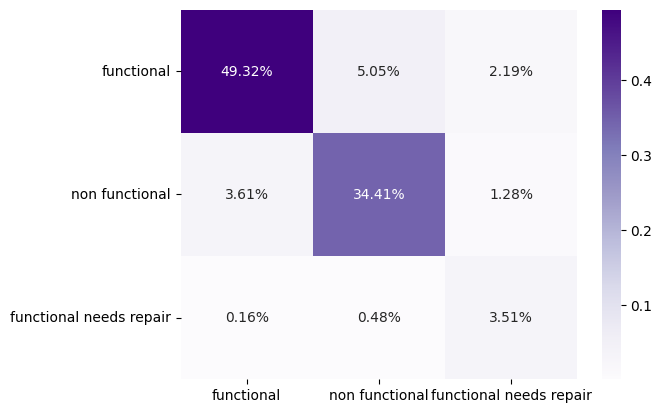

In [79]:
# Heatmap visualisation of the confusion matrix
confusion_matrix_np = np.array(confusion_matrix)
sns.heatmap(confusion_matrix_np/np.sum(confusion_matrix_np), annot=True,
            fmt='.2%', cmap='Purples', xticklabels = ['functional', 'non functional', 'functional needs repair'], yticklabels=['functional', 'non functional', 'functional needs repair'])

## Random Forest

In [65]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

# Defining the Random Forest Classifier model
rf = RandomForestClassifier(numTrees=40, labelCol="label", featuresCol="features")

# Defining the pipeline for applying the preprocessing steps and the Random Forest Classifier model
rf_pipeline = Pipeline(stages=preprocessingStages + [rf])

# Fit the pipeline on the train dataframe
rf_pipeline_model = rf_pipeline.fit(train_df)

# Transform the train dataframe
train_predictions_rf = rf_pipeline_model.transform(train_df)

# Taking the predictions and actual labels into another dataframe
predictionAndLabels_train_rf = train_predictions_rf.select("prediction", "label")

# Evaluating the model on the train dataframe
evaluator = MulticlassClassificationEvaluator(metricName="weightedPrecision")

# Compute accuracy
accuracy = evaluator.evaluate(predictionAndLabels_train_rf, {evaluator.metricName: "accuracy"})

# Compute precision
precision = evaluator.evaluate(predictionAndLabels_train_rf, {evaluator.metricName: "weightedPrecision"})

# Compute recall
recall = evaluator.evaluate(predictionAndLabels_train_rf, {evaluator.metricName: "weightedRecall"})

# Compute F1-score
f1_score = evaluator.evaluate(predictionAndLabels_train_rf, {evaluator.metricName: "f1"})

# Print the computed metrics
print("Random Forest Classifier Model Metrics:")
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1_score))



Random Forest Classifier Model Metrics:
Accuracy: 0.6310
Precision: 0.6936
Recall: 0.6310
F1-score: 0.5478


In [67]:
# Transforming the test dataframe
test_predictions_rf = rf_pipeline_model.transform(test_df)

predictionAndLabels_test_rf = test_predictions_rf.select("prediction","label")

# Evaluating the model on test df
evaluator = MulticlassClassificationEvaluator(metricName="weightedPrecision")
# Compute accuracy
accuracy = evaluator.evaluate(predictionAndLabels_test_rf, {evaluator.metricName: "accuracy"})

# Compute precision
precision = evaluator.evaluate(predictionAndLabels_test_rf, {evaluator.metricName: "weightedPrecision"})

# Compute recall
recall = evaluator.evaluate(predictionAndLabels_test_rf, {evaluator.metricName: "weightedRecall"})

# Compute F1-score
f1_score = evaluator.evaluate(predictionAndLabels_test_rf, {evaluator.metricName: "f1"})

# Print the computed metrics
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1_score))

Accuracy: 0.6220
Precision: 0.6970
Recall: 0.6220
F1-score: 0.5404


## Decision trees

In [81]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

# Defining the Decision Tree Classifier model
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

# Defining the pipeline for applying the preprocessing steps and the Decision Tree Classifier model
dt_pipeline = Pipeline(stages=preprocessingStages + [dt])

# Fit the pipeline on the train dataframe
dt_pipeline_model = dt_pipeline.fit(train_df)

# Transform the train dataframe
train_predictions_dt = dt_pipeline_model.transform(train_df)

# Taking the predictions and actual labels into another dataframe
predictionAndLabels_train_dt = train_predictions_dt.select("prediction", "label")

# Evaluating the model on the train dataframe
evaluator = MulticlassClassificationEvaluator(metricName="weightedPrecision")

# Compute accuracy
accuracy = evaluator.evaluate(predictionAndLabels_train_dt, {evaluator.metricName: "accuracy"})

# Compute precision
precision = evaluator.evaluate(predictionAndLabels_train_dt, {evaluator.metricName: "weightedPrecision"})

# Compute recall
recall = evaluator.evaluate(predictionAndLabels_train_dt, {evaluator.metricName: "weightedRecall"})

# Compute F1-score
f1_score = evaluator.evaluate(predictionAndLabels_train_dt, {evaluator.metricName: "f1"})

# Print the computed metrics
print("Decision Tree Classifier Model Metrics:")
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1_score))


Decision Tree Classifier Model Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000


In [83]:
# Transforming the test dataframe
test_predictions_dt = dt_pipeline_model.transform(test_df)

predictionAndLabels_test_dt = test_predictions_dt.select("prediction","label")

# Evaluating the model on test df
evaluator = MulticlassClassificationEvaluator(metricName="weightedPrecision")
# Compute accuracy
accuracy = evaluator.evaluate(predictionAndLabels_test_dt, {evaluator.metricName: "accuracy"})

# Compute precision
precision = evaluator.evaluate(predictionAndLabels_test_dt, {evaluator.metricName: "weightedPrecision"})

# Compute recall
recall = evaluator.evaluate(predictionAndLabels_test_dt, {evaluator.metricName: "weightedRecall"})

# Compute F1-score
f1_score = evaluator.evaluate(predictionAndLabels_test_dt, {evaluator.metricName: "f1"})

# Print the computed metrics
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1_score))

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
